In [1]:
from Ising import Ising
import torch
import time
from torch.utils.data import DataLoader, Dataset, IterableDataset

In [2]:
%load_ext autoreload
%autoreload 2

We'd like to produce a dataset (defining item retrieval and processing done by the CPU) that produces outputs of the form (states, params, labels),
where:

- states is a tensor of dimension (n, batch), containing batch spin chains of length n
- params is a list of indices-values tuples, indicating which parameters should be assigned to the basis states at the corresponding indices
- labels is a tensor of dimension (batch, 1), containing the probability amplitude of the corresponding state

params should look something like:


In [3]:
test_params = [
    (torch.tensor([0, 1, 2]), torch.tensor([1.5, 2.4])),
    (torch.tensor([3, 4]), torch.tensor([1.0, 0.3])),
]

test_params

[(tensor([0, 1, 2]), tensor([1.5000, 2.4000])),
 (tensor([3, 4]), tensor([1.0000, 0.3000]))]

In [4]:
class IsingIterableDatasetSequential(IterableDataset):
    def __init__(self, dataframe, batch_size, basis):
        """
        Parameters:
            dataframe: pd.DataFrame
                The dataset containing the ground states.
            batch_size: int
                The number of sites to sample in each batch
            basis: torch.Tensor (n, 2**n)
                All energy eigenstates of the Hamiltonian (i.e., all possible spin sequences).
        """

        self.dataframe = dataframe
        self.ground_state_tensor = torch.tensor(
            dataframe["state"].tolist(), device="cpu"
        )

        self.param_tensor = torch.tensor(dataframe["h"], device="cpu")

        # Number of sites in the system
        self.n = basis.shape[0]

        self.batch_size = batch_size
        self.basis = basis

        # Ground state tensor dimensions. The second (ground_state_length)
        # is important for flattened indexing.
        self.dataset_len = self.ground_state_tensor.shape[0]
        self.ground_state_length = 2**self.n

        # The number of labels (probability amplitudes) in the dataset
        self.total_prob_amps = self.dataset_len * self.ground_state_length

    def __iter__(self):
        # Iterate over probability amplitude entries in batch_size steps
        for i in range(0, self.dataset_len * self.ground_state_length, self.batch_size):

            # Flattened index of the start and end of the batch in the ground state tensor
            start_idx = i
            end_idx = min(i + self.batch_size, self.total_prob_amps)
            flattened_idx = torch.arange(start_idx, end_idx)
            labels = self.ground_state_tensor.view(-1)[flattened_idx]

            # Indices for the basis states (circular indexing of the basis set)
            basis_idx = torch.remainder(flattened_idx, self.ground_state_length)
            basis_states = self.basis[:, basis_idx]

            # Indices for the parameters (mapping flattened indices to the ground state or row
            # index in the ground state tensor)
            param_idx = flattened_idx // self.ground_state_length
            params = self.param_tensor[torch.tensor(param_idx)].unsqueeze(1)

            yield basis_states, params, labels

In [5]:
iham = Ising(torch.tensor([4]), periodic=True)
data_path = "TFIM_ground_states/2024-07-24T19-26-39.836"
iham.load_dataset(data_path)

Loaded dataset for system size 4 from TFIM_ground_states/2024-07-24T19-26-39.836/4.arrow.
(h_min, h_step, h_max) = (0.5, 0.01, 1.5).


/home/spandan/Projects/tqs/Ising.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  self.system_size.T, "nearest_neighbor", periodic
/home/spandan/Projects/tqs/Hamiltonian_utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  system_size = torch.tensor(system_size, dtype=torch.int64).reshape(-1)
/home/spandan/Projects/tqs/batch_ising_dataset.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converti

In [6]:
isingds = IsingIterableDatasetSequential(iham.dataset, 10, iham.basis)

In [7]:
for batch in isingds:
    spins, params, labels = batch
    print(spins)
    print(params)
    print(labels)
    print()

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], dtype=torch.float64)
tensor([0.6795, 0.0923, 0.0923, 0.0432, 0.0923, 0.0223, 0.0432, 0.0923, 0.0923,
        0.0432], dtype=torch.float64)

tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5100],
        [0.5100],
        [0.5100],
        [0.5100]], dtype=torch.float64)
tensor([0.0223, 0.0923, 0.0432, 0.0923, 0.0923, 0.6795, 0.6782, 0.0942, 0.0942,
        0.0449], dtype=torch.float64)

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 

/tmp/ipykernel_530333/2205096580.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = self.param_tensor[torch.tensor(param_idx)].unsqueeze(1)


In [8]:
def write_params_to_prefix(
    values, prefix_encoding, n_dim, phys_dim, n_params, batch_size
):
    """
    Parameters:
        values: torch.Tensor (batch_size, n_params)
            The parameter values to write, where each row is a point in parameter space.
        prefix_encoding: torch.Tensor (prefix_dim, batch, input_dim)
            The prefix or input encoding tensor to write to
        n_dim: int
            The number of physical dimensions of the system
        phys_dim: int
            The number of possible values for each site in the chain
        n_params: int
            The number of parameters of the Hamiltonian
        batch_size: int
            The number of points in parameter space that this batch includes
    """

    # Expand each parameter row to a diagonal matrix
    values_diag = torch.diag_embed(values)

    # Identify the prefix_dim-input_dim slice to write to (note that the parameters are
    # written across the entire batch dimension)
    prefix_dim_start = n_dim
    prefix_dim_end = prefix_dim_start + n_params
    input_dim_start = phys_dim + n_dim + 2  # This is param_offset
    input_dim_end = input_dim_start + n_params

    # Write the parameter values to the prefix encoding tensor
    prefix_encoding[
        prefix_dim_start:prefix_dim_end, :batch_size, input_dim_start:input_dim_end
    ] = values_diag.swapaxes(0, 1)

    return prefix_encoding

In [9]:
def wrap_spins_batch(params, spins, phys_dim, system_size):
    """

    Parameters:
        params: torch.Tensor (batch_size, n_params)
            The parameter values to write, where each row is a point in parameter space.
        spins: torch.Tensor (n, batch_size)
            The spin configurations to write, where each column is a point in the dataset.
        phys_dim: int
            The number of possible values for each site in the chain (i.e., each entry in spins)
        system_size: torch.Tensor (n_dim, )
            The number of sites in the system, along each physical dimension
    """

    n_params = params.shape[1]
    n_dim = system_size.shape[0]

    input_dim = phys_dim + n_dim + 2 + n_params
    prefix_len = n_dim + n_params

    n, batch_size = spins.shape
    seq_encoding = torch.zeros(prefix_len + n, batch_size, input_dim)

    size_input = torch.diag(system_size.log())
    parity = system_size % 2

    seq_encoding[:n_dim, :, phys_dim : (phys_dim + n_dim)] = size_input.unsqueeze(1)

    seq_encoding[:n_dim, :, phys_dim + n_dim] = parity.unsqueeze(1)

    seq_encoding = write_params_to_prefix(
        params, seq_encoding, n_dim, phys_dim, n_params, batch_size
    )

    seq_encoding[prefix_len:, :, :phys_dim] = torch.functional.F.one_hot(
        spins.to(torch.int64), num_classes=phys_dim
    )

    return seq_encoding

In [10]:
isingds = IsingIterableDatasetSequential(iham.dataset, 10, iham.basis)
for batch in isingds:
    basis_states, params, labels = batch
    print(basis_states)
    print(params)
    print(labels)

/tmp/ipykernel_530333/2205096580.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = self.param_tensor[torch.tensor(param_idx)].unsqueeze(1)


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], dtype=torch.float64)
tensor([0.6795, 0.0923, 0.0923, 0.0432, 0.0923, 0.0223, 0.0432, 0.0923, 0.0923,
        0.0432], dtype=torch.float64)
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5100],
        [0.5100],
        [0.5100],
        [0.5100]], dtype=torch.float64)
tensor([0.0223, 0.0923, 0.0432, 0.0923, 0.0923, 0.6795, 0.6782, 0.0942, 0.0942,
        0.0449], dtype=torch.float64)
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [11]:
basis_states

tensor([[1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1]])

In [12]:
import plotly.graph_objects as go
import numpy as np


def plot_tensor(tens, labels, opacity=0.7, size=5):

    x = np.arange(tens.shape[0])
    y = np.arange(tens.shape[1])
    z = np.arange(tens.shape[2])

    xlen = len(x)
    ylen = len(y)
    zlen = len(z)

    print(f"(x, y, z) = ({xlen}, {ylen}, {zlen})")

    X, Y, Z = np.meshgrid(x, y, z)

    color_function = np.vectorize(lambda x, y, z: tens[x, y, z])

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=X.flatten(),
                y=Y.flatten(),
                z=Z.flatten(),
                mode="markers",
                marker=dict(
                    size=size,
                    # color=tens.swapaxes(1, 2)
                    # .swapaxes(0, 2)
                    # .swapaxes(1, 2)
                    # .flatten(),  # set color to an array/list of desired values
                    color=color_function(X, Y, Z).flatten(),
                    colorscale="bupu",  # choose a colorscale
                    opacity=opacity,
                ),
            )
        ]
    )

    fig.update_layout(
        scene=dict(xaxis_title=labels[0], yaxis_title=labels[1], zaxis_title=labels[2]),
    )
    fig.show()

In [13]:
params

tensor([[1.5000],
        [1.5000],
        [1.5000],
        [1.5000],
        [1.5000],
        [1.5000]], dtype=torch.float64)

In [14]:
plot_tensor(
    wrap_spins_batch(params, basis_states, 2, torch.tensor([4])),
    ["Prefix", "Batch", "Input"],
    opacity=1,
)

(x, y, z) = (6, 6, 6)


In [15]:
labels

tensor([0.1210, 0.2171, 0.1927, 0.2171, 0.2171, 0.4719], dtype=torch.float64)

In [16]:
plot_tensor(labels.view(1, -1, 1), ["x", "y", "z"], opacity=1)

(x, y, z) = (1, 6, 1)


## Probability Distributions


In [17]:
from batch_ising_dataset import IsingDataset

In [18]:
iham.dataset

,N,h,energy,state
0,4,0.50,-4.271558,"[0.6795005617018101, 0.09226204611239203, 0.09..."
1,4,0.51,-4.283337,"[0.6781932021588397, 0.09419487270806987, 0.09..."
2,4,0.52,-4.295405,"[0.6768484230388768, 0.09612717601562645, 0.09..."
3,4,0.53,-4.307764,"[0.6754660408065879, 0.09805843157014091, 0.09..."
4,4,0.54,-4.320415,"[0.6740459180156488, 0.09998809527863438, 0.09..."
...,...,...,...,...
96,4,1.46,-6.624868,"[0.47857563015576166, 0.21510241025358673, 0.2..."
97,4,1.47,-6.658510,"[0.47687053493020953, 0.2156062783775707, 0.21..."
98,4,1.48,-6.692248,"[0.47518411978084873, 0.2161002547256103, 0.21..."
99,4,1.49,-6.726082,"[0.47351625445001, 0.21658455774827434, 0.2165..."


In [19]:
testds = IsingDataset(iham.dataset, 10, iham.basis)

In [20]:
testds.param_tensor

tensor([0.5000, 0.5100, 0.5200, 0.5300, 0.5400, 0.5500, 0.5600, 0.5700, 0.5800,
        0.5900, 0.6000, 0.6100, 0.6200, 0.6300, 0.6400, 0.6500, 0.6600, 0.6700,
        0.6800, 0.6900, 0.7000, 0.7100, 0.7200, 0.7300, 0.7400, 0.7500, 0.7600,
        0.7700, 0.7800, 0.7900, 0.8000, 0.8100, 0.8200, 0.8300, 0.8400, 0.8500,
        0.8600, 0.8700, 0.8800, 0.8900, 0.9000, 0.9100, 0.9200, 0.9300, 0.9400,
        0.9500, 0.9600, 0.9700, 0.9800, 0.9900, 1.0000, 1.0100, 1.0200, 1.0300,
        1.0400, 1.0500, 1.0600, 1.0700, 1.0800, 1.0900, 1.1000, 1.1100, 1.1200,
        1.1300, 1.1400, 1.1500, 1.1600, 1.1700, 1.1800, 1.1900, 1.2000, 1.2100,
        1.2200, 1.2300, 1.2400, 1.2500, 1.2600, 1.2700, 1.2800, 1.2900, 1.3000,
        1.3100, 1.3200, 1.3300, 1.3400, 1.3500, 1.3600, 1.3700, 1.3800, 1.3900,
        1.4000, 1.4100, 1.4200, 1.4300, 1.4400, 1.4500, 1.4600, 1.4700, 1.4800,
        1.4900, 1.5000], dtype=torch.float64)

In [21]:
import math

In [22]:
gaussian_coeff = 1 / math.sqrt(2 * math.pi)
gaussian_mean = 1.0
gaussian_std = 0.05

In [23]:
probability_distribution = lambda param: gaussian_coeff * torch.exp(
    -0.5 * (((param - gaussian_mean) ** 2) / gaussian_std**2)
)

In [24]:
probability_distribution(testds.param_tensor)

tensor([7.6946e-23, 5.5730e-22, 3.8781e-21, 2.5929e-20, 1.6656e-19, 1.0280e-18,
        6.0958e-18, 3.4730e-17, 1.9011e-16, 9.9984e-16, 5.0523e-15, 2.4529e-14,
        1.1442e-13, 5.1278e-13, 2.2080e-12, 9.1347e-12, 3.6310e-11, 1.3867e-10,
        5.0881e-10, 1.7938e-09, 6.0759e-09, 1.9773e-08, 6.1826e-08, 1.8574e-07,
        5.3610e-07, 1.4867e-06, 3.9613e-06, 1.0141e-05, 2.4942e-05, 5.8943e-05,
        1.3383e-04, 2.9195e-04, 6.1190e-04, 1.2322e-03, 2.3841e-03, 4.4318e-03,
        7.9155e-03, 1.3583e-02, 2.2395e-02, 3.5475e-02, 5.3991e-02, 7.8950e-02,
        1.1092e-01, 1.4973e-01, 1.9419e-01, 2.4197e-01, 2.8969e-01, 3.3322e-01,
        3.6827e-01, 3.9104e-01, 3.9894e-01, 3.9104e-01, 3.6827e-01, 3.3322e-01,
        2.8969e-01, 2.4197e-01, 1.9419e-01, 1.4973e-01, 1.1092e-01, 7.8950e-02,
        5.3991e-02, 3.5475e-02, 2.2395e-02, 1.3583e-02, 7.9155e-03, 4.4318e-03,
        2.3841e-03, 1.2322e-03, 6.1190e-04, 2.9195e-04, 1.3383e-04, 5.8943e-05,
        2.4942e-05, 1.0141e-05, 3.9613e-

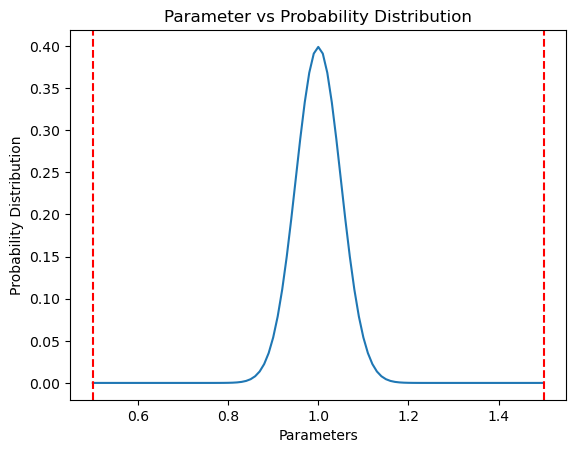

In [25]:
import matplotlib.pyplot as plt

params = testds.param_tensor.flatten().numpy()
probabilities = probability_distribution(testds.param_tensor).flatten().numpy()

plt.plot(params, probabilities)
plt.xlabel("Parameters")
plt.ylabel("Probability Distribution")
plt.title("Parameter vs Probability Distribution")

# Add red vertical lines at specific horizontal axis values
line1_value = 0.5
line2_value = 1.5
plt.axvline(x=line1_value, color="red", linestyle="--")
plt.axvline(x=line2_value, color="red", linestyle="--")

plt.show()

In [26]:
import ipywidgets as widgets
from IPython.display import display

# Define the initial values
gaussian_coeff_init = 1 / math.sqrt(2 * math.pi)
gaussian_mean_init = 1.0
gaussian_std_init = 0.05

# Define the sliders
gaussian_mean_slider = widgets.FloatSlider(
    value=gaussian_mean_init, min=0, max=2, step=0.01, description="Mean:"
)
gaussian_std_slider = widgets.FloatSlider(
    value=gaussian_std_init, min=0.01, max=2, step=0.01, description="Std:"
)


# Define a function to update the plot
def update_plot(gaussian_mean, gaussian_std):
    probability_distribution = (
        lambda param: gaussian_coeff
        * (gaussian_std**-1)
        * torch.exp(-0.5 * (((param - gaussian_mean) ** 2) / gaussian_std**2))
    )

    params = testds.param_tensor.flatten().numpy()
    probabilities = probability_distribution(testds.param_tensor).flatten().numpy()

    plt.plot(params, probabilities)
    plt.xlabel("Parameters")
    plt.ylabel("Probability Distribution")
    plt.title("Parameter vs Probability Distribution")

    # Add red vertical lines at specific horizontal axis values
    line1_value = 0.5
    line2_value = 1.5
    plt.axvline(x=line1_value, color="red", linestyle="--")
    plt.axvline(x=line2_value, color="red", linestyle="--")


# Use the interactive function to bind the sliders to the update function
widgets.interactive(
    update_plot, gaussian_mean=gaussian_mean_slider, gaussian_std=gaussian_std_slider
)

interactive(children=(FloatSlider(value=1.0, description='Mean:', max=2.0, step=0.01), FloatSlider(value=0.05,…

In [27]:
test_expand = torch.arange(0, 10)
test_expand

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
import sys

memory_usage = sys.getsizeof(test_expand)
print(f"Memory usage of test_expand: {memory_usage} bytes")

Memory usage of test_expand: 80 bytes


In [29]:
print(
    f"Memory usage of test_expand before repeat_interleave: {test_expand.element_size() * test_expand.nelement() / 1024} KB"
)

Memory usage of test_expand before repeat_interleave: 0.078125 KB


In [30]:
test_expand_repeated = test_expand.repeat_interleave(1000)

In [31]:
test_expand_repeated

tensor([0, 0, 0,  ..., 9, 9, 9])

In [32]:
print(
    f"Memory usage of test_expand after repeat_interleave: {test_expand_repeated.element_size() * test_expand_repeated.nelement() / 1024} KB"
)

Memory usage of test_expand after repeat_interleave: 78.125 KB


In [33]:
class SlowTensor(torch.Tensor):
    def __init__(self, base_tensor: torch.tensor):
        """
        A thin wrapper around a PyTorch tensor that has the same effect as repeat_interleave
        without the memory overhead.

        Parameters:
            base_tensor: torch.Tensor
                The tensor to "slow down" (i.e., repeat each element of)
            slowness: int
                The factor by which to slow down the tensor (i.e., the number of times to repeat each element)
        """
        super().__init__()

        self.base_tensor = base_tensor
        self.slowness = 1

    def set_slowness(self, slowness):
        self.slowness = slowness

    def __getitem__(self, idx):
        return super().__getitem__(idx // self.slowness)

    def __len__(self):
        return self.n * self.slowness

In [37]:
from batch_ising_dataset import IsingRandomSampler

In [38]:
ising_sampler = IsingRandomSampler(
    data_source=testds, replacement=True, num_samples=12, generator=None
)

In [39]:
retrieved = None
for sample in ising_sampler:
    basis, params, labels = sample
    break

/home/spandan/Projects/tqs/batch_ising_dataset.py:99: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [40]:
basis

tensor([[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
         0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
         1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,

In [41]:
testres = torch.arange(0, 10)

In [42]:
testres

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [43]:
testres >= 0

tensor([True, True, True, True, True, True, True, True, True, True])

In [44]:
testres.isclose(torch.tensor(0))

tensor([ True, False, False, False, False, False, False, False, False, False])

In [45]:
testres[testres.isclose(torch.tensor(0))] = 1000

In [46]:
testres

tensor([1000,    1,    2,    3,    4,    5,    6,    7,    8,    9])

In [47]:
gaussian_coeff = 1 / math.sqrt(2 * math.pi)
gaussian_mean = 1.0
gaussian_std = 0.05


probability_distribution = lambda param: gaussian_coeff * torch.exp(
    -0.5 * (((param - gaussian_mean) ** 2) / gaussian_std**2)
)

In [48]:
torch.ones(4)

tensor([1., 1., 1., 1.])

In [49]:
testds[torch.tensor([2, 4, 10, 1000])]

(tensor([[0, 0, 1, 1],
         [0, 1, 0, 0],
         [1, 0, 1, 0],
         [0, 0, 0, 0]]),
 tensor([[0.5000],
         [0.5000],
         [0.5000],
         [1.1200]], dtype=torch.float64),
 tensor([0.0923, 0.0923, 0.0223, 0.1903], dtype=torch.float64))

In [50]:
test = torch.arange(1, 4)
test

tensor([1, 2, 3])

In [51]:
test.view(test.shape[0], 1).expand(test.shape[0], 3).contiguous().view(-1)

tensor([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [74]:
sampler = IsingRandomSampler(
    data_source=testds,
    replacement=True,
    num_samples=10,
    generator=None,
    probability_distribution=probability_distribution,
)

In [78]:
for sample in sampler:
    print(sample)

(tensor([[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
         0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
         0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
         0, 0, 1, 1],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
         1, 1, 1, 0],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
         1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
         1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0

In [81]:
testslowtens = SlowTensor(torch.arange(0, 10))

In [82]:
testslowtens.set_slowness(2)

In [83]:
testslowtens

SlowTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [84]:
testslowtens.slowness

2

In [85]:
sampler.sampled.shape

torch.Size([101, 16])

In [86]:
plot_tensor(sampler.sampled.unsqueeze(1), labels=["Point", "State", ""], size=3)

(x, y, z) = (101, 1, 16)


In [57]:
probs = probability_distribution(sampler.param_tensor)
probs

tensor([7.6946e-23, 5.5730e-22, 3.8781e-21, 2.5929e-20, 1.6656e-19, 1.0280e-18,
        6.0958e-18, 3.4730e-17, 1.9011e-16, 9.9984e-16, 5.0523e-15, 2.4529e-14,
        1.1442e-13, 5.1278e-13, 2.2080e-12, 9.1347e-12, 3.6310e-11, 1.3867e-10,
        5.0881e-10, 1.7938e-09, 6.0759e-09, 1.9773e-08, 6.1826e-08, 1.8574e-07,
        5.3610e-07, 1.4867e-06, 3.9613e-06, 1.0141e-05, 2.4942e-05, 5.8943e-05,
        1.3383e-04, 2.9195e-04, 6.1190e-04, 1.2322e-03, 2.3841e-03, 4.4318e-03,
        7.9155e-03, 1.3583e-02, 2.2395e-02, 3.5475e-02, 5.3991e-02, 7.8950e-02,
        1.1092e-01, 1.4973e-01, 1.9419e-01, 2.4197e-01, 2.8969e-01, 3.3322e-01,
        3.6827e-01, 3.9104e-01, 3.9894e-01, 3.9104e-01, 3.6827e-01, 3.3322e-01,
        2.8969e-01, 2.4197e-01, 1.9419e-01, 1.4973e-01, 1.1092e-01, 7.8950e-02,
        5.3991e-02, 3.5475e-02, 2.2395e-02, 1.3583e-02, 7.9155e-03, 4.4318e-03,
        2.3841e-03, 1.2322e-03, 6.1190e-04, 2.9195e-04, 1.3383e-04, 5.8943e-05,
        2.4942e-05, 1.0141e-05, 3.9613e-

In [58]:
torch.ones(4)

tensor([1., 1., 1., 1.])

In [68]:
ZEROTOL = 1e-2

In [73]:
probs.isclose(torch.tensor(0.0, dtype=torch.float64), atol=ZEROTOL)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True])